In [3]:
import spatialdata
import spatialdata_plot
import napari
import napari_spatialdata

import sopa.segmentation
import sopa.io

import ray

In [13]:
path_to_image="/Volumes/ag_coscia/Jose/P26_BCCN/P26E02_FrameSlides/991/qupath_8k_subset/991_subset.ome.tif"

In [14]:
# The line below creates a toy dataset for this tutorial
# To load your own data, such as MERSCOPE data, you can do `sdata = sopa.io.merscope("/path/to/region_0")`
# For more details, see https://gustaveroussy.github.io/sopa/api/io/
sdata = sopa.io.ome_tif(path_to_image, as_image=False)
sdata

INFO     `dims` is specified redundantly: found also inside `data`.                                                


SpatialData object
└── Images
      └── '991_subset': DataTree[cyx] (15, 8000, 8000), (15, 4000, 4000), (15, 2000, 2000), (15, 1000, 1000), (15, 500, 500)
with coordinate systems:
    ▸ 'pixels', with elements:
        991_subset (Images)

In [16]:
patches = sopa.segmentation.Patches2D(sdata, element_name="991_subset", patch_width=1200, patch_overlap=50)
patches.write()

ValueError: Invalid element type: <class 'datatree.datatree.DataTree'>

In [6]:
from sopa._sdata import get_spatial_image
print(get_spatial_image(sdata=sdata).c.values)

['750_bg' '647_bg' '555_bg' '488_bg' 'DAPI_bg' 'Vimentin' 'CD3e' 'panCK'
 'CD8' 'DAPI_1' 'COL1A1' 'CD20' 'CD68' 'Ki67' 'DAPI_2']


In [7]:
channels = ["DAPI_bg"]

In [10]:
method = sopa.segmentation.methods.cellpose_patch(diameter=35, channels=channels, flow_threshold=2, cellprob_threshold=-6)

In [11]:
segmentation = sopa.segmentation.StainingSegmentation(sdata, method, channels, min_area=2500)

In [12]:
# The cellpose boundaries will be temporary saved here. You can choose a different path
cellpose_temp_dir = "/Users/jnimoca/Jose_BI/P26_SOPA_seg/991_subset.zarr/.sopa_cache/cellpose"

In [13]:
segmentation.write_patches_cells(cellpose_temp_dir)

[WARNING] (sopa.segmentation.stainings) Running segmentation in a sequential manner. This is not recommended on large images because it can be extremely slow (see https://github.com/gustaveroussy/sopa/discussions/36 for more details)
Run all patches: 100%|██████████| 49/49 [09:40<00:00, 11.84s/it]


it took 10min for 3gb file (pyramid, 15 channels, 8000x8000 pixels)

In [15]:
cells = sopa.segmentation.StainingSegmentation.read_patches_cells(cellpose_temp_dir)

Reading patches: 100%|██████████| 49/49 [00:00<00:00, 295.11it/s]
[INFO] (sopa.segmentation.stainings) Found 2153 total cells


In [16]:
cells = sopa.segmentation.shapes.solve_conflicts(cells)

Resolving conflicts: 100%|██████████| 220/220 [00:00<00:00, 9327.55it/s]


In [8]:
shapes_key = "sopa_patches" # name of the key given to the cells in sdata.shapes

In [17]:
sopa.segmentation.StainingSegmentation.add_shapes(sdata, cells, image_key="991_subset", shapes_key=shapes_key)

/opt/homebrew/Caskroom/mambaforge/base/envs/SOPA/lib/python3.10/site-packages/spatialdata/_core/_elements.py:92: UserWarning: Key `sopa_patches` already exists. Overwriting it.
  self._check_key(key, self.keys(), self._shared_keys)
[INFO] (sopa.segmentation.stainings) Added 2106 cell boundaries in sdata['sopa_patches']


In [18]:
sdata

SpatialData object with:
├── Images
│     └── '991_subset': MultiscaleSpatialImage[cyx] (15, 8000, 8000), (15, 4000, 4000), (15, 2000, 2000), (15, 1000, 1000), (15, 500, 500)
└── Shapes
      └── 'sopa_patches': GeoDataFrame shape: (2106, 1) (2D shapes)
with coordinate systems:
▸ 'pixels', with elements:
        991_subset (Images), sopa_patches (Shapes)

In [23]:
sdata.write("/Users/jnimoca/Jose_BI/P26_SOPA_seg/991.zarr", overwrite=True)

In [5]:
sdata = spatialdata.SpatialData.read("/Users/jnimoca/Jose_BI/P26_SOPA_seg/991.zarr")

In [6]:
sdata

SpatialData object, with associated Zarr store: /Users/jnimoca/Jose_BI/P26_SOPA_seg/991.zarr
├── Images
│     └── '991_subset': DataTree[cyx] (15, 8000, 8000), (15, 4000, 4000), (15, 2000, 2000), (15, 1000, 1000), (15, 500, 500)
└── Shapes
      └── 'sopa_patches': GeoDataFrame shape: (2106, 1) (2D shapes)
with coordinate systems:
    ▸ 'pixels', with elements:
        991_subset (Images), sopa_patches (Shapes)

INFO     Value for parameter 'color' appears to be a color, using it as such.                                      


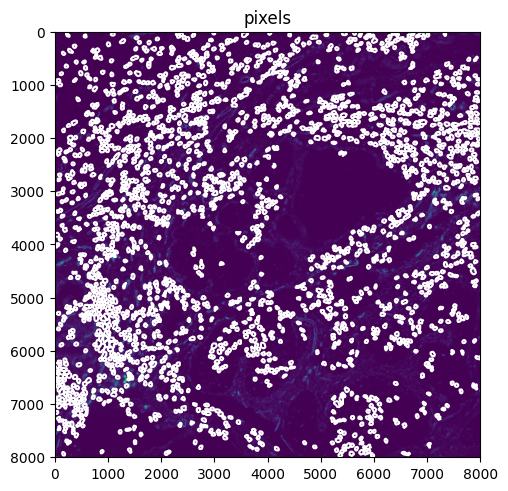

In [13]:
sdata\
    .pl.render_points(size=0.01, color="r", alpha=0.5)\
    .pl.render_images(channel=5)\
    .pl.render_shapes(shapes_key, outline=True, fill_alpha=0, outline_color="w")\
    .pl.show("pixels")

In [18]:
napari_spatialdata.Interactive(sdata)

2024-07-04 13:05:20.984 | INFO     | napari_spatialdata._view:_on_layer_update:327 - Updating layer.
2024-07-04 13:05:20.985 | INFO     | napari_spatialdata._view:_on_layer_update:327 - Updating layer.
OMP: Info #276: omp_set_nested routine deprecated, please use omp_set_max_active_levels instead.
2024-07-04 13:09:06.810 | INFO     | napari_spatialdata._view:_on_layer_update:327 - Updating layer.
2024-07-04 13:09:06.812 | INFO     | napari_spatialdata._view:_on_layer_update:327 - Updating layer.


This works, segmentation did not work
Next steps:
1. Find workflow to lower feedback time with segmentation
2. Optimize to best segmentation

# Feedback cycle

In [5]:
path_to_image="/Volumes/ag_coscia/Jose/P26_BCCN/P26E02_FrameSlides/991/qupath_8k_subset/991_subset.ome.tif"

In [6]:
sdata = sopa.io.ome_tif(path_to_image, as_image=False)

INFO     `dims` is specified redundantly: found also inside `data`.                                                


In [7]:
sdata

SpatialData object
└── Images
      └── '991_subset': DataTree[cyx] (15, 8000, 8000), (15, 4000, 4000), (15, 2000, 2000), (15, 1000, 1000), (15, 500, 500)
with coordinate systems:
    ▸ 'pixels', with elements:
        991_subset (Images)

In [12]:
image_key = '991_subset'
patches = sopa.segmentation.Patches2D(sdata, image_key, patch_width=1200, patch_overlap=100)
patches.write()

ValueError: Invalid element type: <class 'datatree.datatree.DataTree'>

In [ ]:
channels = ["DAPI_bg"]
method = sopa.segmentation.methods.cellpose_patch(diameter=20, channels=channels, model_type="nuclei", flow_threshold=0.4, cellprob_threshold=0)
segmentation = sopa.segmentation.StainingSegmentation(sdata, method, channels, min_area=2500)
cellpose_temp_dir = "/Users/jnimoca/Jose_BI/P26_SOPA_seg/991_subset.zarr/.sopa_cache/cellpose"

In [ ]:
ray.init()
@ray.remote
def process_patch(cellpose_temp_dir, patch_index):
    segmentation.write_patch_cells(cellpose_temp_dir, patch_index)

In [ ]:
# Execute the function in parallel
futures = [process_patch.remote(cellpose_temp_dir, patch_index) for patch_index in range(len(sdata['sopa_patches']))]